<h1 style="text-align: center;color:blue"><em>Daniel Juravski 206082323</em></h1>

## Question 01:

### Part 1

E[${Y^b}$]-E[${Y^a}$] = $\frac{289}{350}$ - $\frac{273}{350}$ = $\frac{8}{175}$ = 4.57%

### Part 2

Small rocks:

E[${Y^a}$]-E[${Y^b}$] = $\frac{81}{87}$  - $\frac{234}{270}$ = $\frac{28}{435}$ = 6.43%

Big rocks:

E[${Y^a}$]-E[${Y^b}$] = $\frac{192}{263}$ - $\frac{55}{80}$ = $\frac{179}{4208}$ = 4.25%

### Part 3

$(\frac{28}{435}*357 + \frac{179}{4208}*343) / 700$ = 5.36%

### Part 4

$P(A=a|small)=\frac{87}{357}$

$P(A=b|small)=\frac{270}{357}$

$P(A=a|big)=\frac{263}{343}$

$P(A=b|big)=\frac{80}{343}$

$(\frac{81}{87}*(87*\frac{357}{87}) + \frac{192}{263}*(263*\frac{343}{263})/{700}$ - $(\frac{234}{270}*(270*\frac{357}{270}) + \frac{55}{80}*(80*\frac{343}{80})/{700}$ = 

= $(81*\frac{357}{87} + 192*\frac{343}{263})/700$ - $(234*\frac{357}{270} + 55*\frac{343}{80})/700$ = 

= $\frac{582.782}{700}$ - $\frac{545.2125}{700}$ = 

= $\frac{37.5695}{700}$ = 

= $0.0536$ = 5.36%

## Question 02:

marked_samples = [ ]

WHILE (unmarked # of treated samples > 0 and unmarked # of untreated samples > 0) DO

   c <- flip a coin
   
    IF c is 'heads' THEN
    
        treated_sample <- pick randomaly an unmarked treated sample (and mark it)
        
        untreated_sample <- pick the closest (to the treated_sample) unmarked untreated sample (and mark it)
        
    ELSE (c is 'tails')
    
        untreated_sample <- pick randomaly an unmarked untreated sample (and mark it)
        
        treated_sample <- pick the closest (to the untreated_sample) unmarked treated sample (and mark it)
        
    marked_samples.insert((treated_sample, untreated_sample))
    
RETURN marked_samples

The algorithm above is an expansion to the algorithm that we saw in class. The addition here is that the total distribution isn't derived only from the leading untreated samples (as we saw in class), but also from the untreated samples (i.e. when the coin is tails). In that way, we make up the distribution to be composed out of both untreated and treated samples - samples that seem to represent the entire population (We still need to define the 'closest' metric when we pick the closest samples to each other, maybe Mahalanobis metric can make a good job with that sampling).



## Question 03:

In [1]:
from causallib.datasets import load_nhefs
data = load_nhefs()

### Part 1

In [2]:
from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW

learner = LogisticRegression(penalty='none',
                             solver='lbfgs',
                             max_iter=1000)
ipw = IPW(learner)
ipw.fit(data.X, data.a)

# cassual_effect
potential_outcomes = ipw.estimate_population_outcome(data.X, data.a, data.y)
cassual_effect = ipw.estimate_effect(potential_outcomes[1], potential_outcomes[0])

# observed_effect
observed_outcomes = data.y.groupby(data.a).mean()
observed_effect = observed_outcomes[1] - observed_outcomes[0]

print("The observed effect is E[Y|A=1]-E[Y|A=0]:")
observed_effect


The observed effect is E[Y|A=1]-E[Y|A=0]:


2.540581454955886

### Part 2

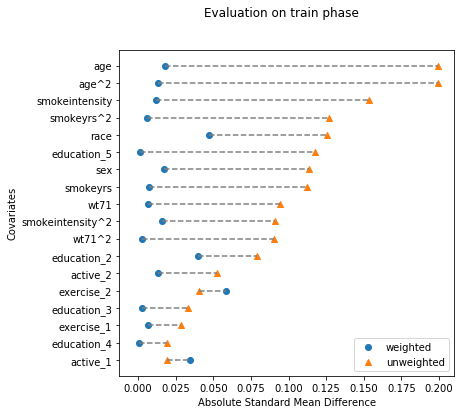

In [3]:
%matplotlib inline
from causallib.evaluation import PropensityEvaluator

evaluator = PropensityEvaluator(ipw)
evaluation_results = evaluator.evaluate_simple(data.X, data.a, data.y, plots=["covariate_balance_love"])
fig = evaluation_results.plots["covariate_balance_love"].get_figure()
fig.set_size_inches(6, 6)

The most biased variable is the "age" variable.

### Part 3

The function below divides the population's data by the <i>var</i> variable into <i>k</i> groups. A group that do not contain both untreadted and treated case is ignored and is not averaged.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def group_and_observe_by(var, k, plot=True):
    # make group intervals
    step_size = (data.X[var].max() - data.X[var].min())/k
    step_size = int(round(step_size))
    groups = range(data.X[var].min(), data.X[var].max() + step_size, step_size)
    print("The groups' intervals are: ", list(groups))
    grouped = pd.cut(data.X[var], bins=groups, include_lowest=True)
    grouped.head()

    # get observed diffs by the groups
    observed_diff = data.y.groupby([data.a, grouped]).mean()
    observed_diff = observed_diff.xs(1) - observed_diff.xs(0)
    observed_diff = observed_diff.rename("observed_effect")
    if plot:
        ax = observed_diff.plot(kind="barh")
        ax.set_xlabel(var)
        ax.set_xlabel("observed_effect")
        plt.show()

    # get groups' frequency
    frequency = grouped.value_counts(sort=False)
    frequency.rename("counts", inplace=True)
    if plot:
        ax = frequency.plot(kind="barh")
        ax.set_xlabel("counts")
        plt.show()
    
    # get propensity based on the groups
    by_var = observed_diff.to_frame().join(frequency)
    tx_distribution = data.a.groupby(grouped, observed=True).value_counts()
    tx_distribution = tx_distribution.unstack("qsmk")
    tx_distribution["propensity"] = tx_distribution[1] / tx_distribution.sum(axis="columns")
    by_var = by_var.join(tx_distribution)
    print(by_var)

    # get weighted average
    # drop nan(s)
    masked_data = np.ma.masked_array(by_var["observed_effect"], np.isnan(by_var["observed_effect"]))
    avg = np.ma.average(masked_data, weights=by_var["counts"])
    print("\nThe average observed effect (factoring in the size of each {0} {1} groups) is: {2}"
          .format(var, k, avg))
    
    return avg

The groups' intervals are:  [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]


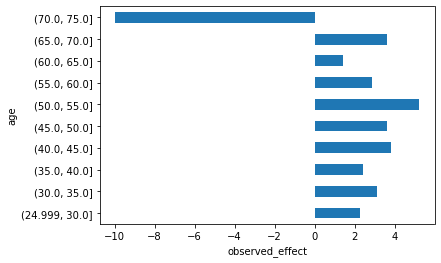

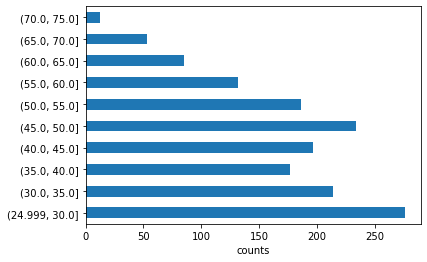

                observed_effect  counts    0   1  propensity
age                                                         
(24.999, 30.0]         2.263298     276  228  48    0.173913
(30.0, 35.0]           3.100541     214  160  54    0.252336
(35.0, 40.0]           2.433750     177  136  41    0.231638
(40.0, 45.0]           3.801950     197  146  51    0.258883
(45.0, 50.0]           3.603730     234  181  53    0.226496
(50.0, 55.0]           5.238368     186  133  53    0.284946
(55.0, 60.0]           2.871668     132   81  51    0.386364
(60.0, 65.0]           1.402340      85   55  30    0.352941
(65.0, 70.0]           3.602345      53   38  15    0.283019
(70.0, 75.0]          -9.985035      12    5   7    0.583333

The average observed effect (factoring in the size of each age 10 groups) is: 3.1002018883702958


3.1002018883702958

In [5]:
group_and_observe_by("age", k=10)

### Part 4

The groups' intervals are:  [1, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81]


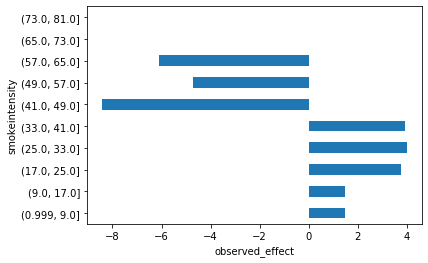

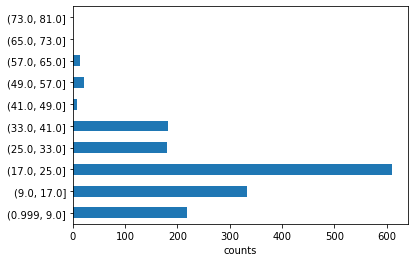

                observed_effect  counts      0      1  propensity
smokeintensity                                                   
(0.999, 9.0]           1.493204     219  135.0   84.0    0.383562
(9.0, 17.0]            1.475089     333  236.0   97.0    0.291291
(17.0, 25.0]           3.779998     610  484.0  126.0    0.206557
(25.0, 33.0]           3.985627     179  131.0   48.0    0.268156
(33.0, 41.0]           3.923470     181  143.0   38.0    0.209945
(41.0, 49.0]          -8.418486       8    7.0    1.0    0.125000
(49.0, 57.0]          -4.736244      22   17.0    5.0    0.227273
(57.0, 65.0]          -6.113288      13   10.0    3.0    0.230769
(65.0, 73.0]                NaN       0    NaN    NaN         NaN
(73.0, 81.0]                NaN       1    NaN    1.0    1.000000

The average observed effect (factoring in the size of each smokeintensity 10 groups) is: 2.745413810751163


2.745413810751163

In [6]:
group_and_observe_by("smokeintensity", k=10)

- We should pay attention to the groups' division - while in the (73.0, 81.0] group there was only a single case of a quit smoker sample (and none non-quit smoker samples), in the (65.0, 73.0] group there wasn't any case of samples (that range has come from the equal range division).
- We can see that the vast majority of the samples were in the (0.999, 41.0] - what makes sense since smokeintensity of above 41 per day seems to be extreme cases and probably not easy to quit them.
- That effect makes sense compared to the age effect:
    - We can see that as the smokeintensity's ASMD is lower than the age's ASMD, so there effect proportion.
    - We can see that while the observed effect is 2.54, the smokeintensity effect is above it (as the age's effect).
    - We should pay attention that the massive positive effect caused by the smokeintensity var is in the (0.999, 41.0], cause we can estimate that if a person that was a smoker of more than 41 cigarettes a day - quit smoking, there some major circumstances for this (like super fatal diseases) that they could cause the dramatic weight lose.

### Part 5

In [7]:
def effect_by_k_groups(var):
    effects = []
    xs = range(1, 21)
    for i in xs:
        effects.append(group_and_observe_by(var, k=i, plot=False))

    plt.plot(xs, effects)
    plt.show()

The groups' intervals are:  [25, 74]
                observed_effect  counts     0    1  propensity
age                                                           
(24.999, 74.0]         2.540581    1566  1163  403    0.257344

The average observed effect (factoring in the size of each age 1 groups) is: 2.540581454955886
The groups' intervals are:  [25, 49, 73, 97]
                observed_effect  counts      0      1  propensity
age                                                              
(24.999, 49.0]         3.226089    1041  811.0  230.0    0.220941
(49.0, 73.0]           2.845498     523  352.0  171.0    0.326960
(73.0, 97.0]                NaN       2    NaN    2.0    1.000000

The average observed effect (factoring in the size of each age 2 groups) is: 3.098819557759759
The groups' intervals are:  [25, 41, 57, 73, 89]
                observed_effect  counts      0      1  propensity
age                                                              
(24.999, 41.0]         2.4

                observed_effect  counts      0     1  propensity
age                                                             
(24.999, 29.0]         2.483203     235  193.0  42.0    0.178723
(29.0, 33.0]           1.675723     164  126.0  38.0    0.231707
(33.0, 37.0]           2.614970     156  125.0  31.0    0.198718
(37.0, 41.0]           2.672729     146  108.0  38.0    0.260274
(41.0, 45.0]           4.712200     163  118.0  45.0    0.276074
(45.0, 49.0]           4.633519     177  141.0  36.0    0.203390
(49.0, 53.0]           5.032379     161  117.0  44.0    0.273292
(53.0, 57.0]           2.778288     152  100.0  52.0    0.342105
(57.0, 61.0]           3.001882      83   50.0  33.0    0.397590
(61.0, 65.0]           1.293355      64   42.0  22.0    0.343750
(65.0, 69.0]           3.990800      46   34.0  12.0    0.260870
(69.0, 73.0]          -4.507361      17    9.0   8.0    0.470588
(73.0, 77.0]                NaN       2    NaN   2.0    1.000000

The average observed eff


The average observed effect (factoring in the size of each age 20 groups) is: 3.1821877028822345


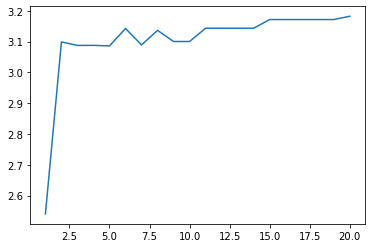

In [8]:
effect_by_k_groups("age")

The groups' intervals are:  [1, 80]
                observed_effect  counts     0    1  propensity
smokeintensity                                                
(0.999, 80.0]          2.540581    1566  1163  403    0.257344

The average observed effect (factoring in the size of each smokeintensity 1 groups) is: 2.540581454955886
The groups' intervals are:  [1, 41, 81]
                observed_effect  counts     0    1  propensity
smokeintensity                                                
(0.999, 41.0]          2.697641    1522  1129  393    0.258213
(41.0, 81.0]          -3.423915      44    34   10    0.227273

The average observed effect (factoring in the size of each smokeintensity 2 groups) is: 2.525643075109903
The groups' intervals are:  [1, 27, 53, 79, 105]
                observed_effect  counts      0      1  propensity
smokeintensity                                                   
(0.999, 27.0]          2.333753    1163  855.0  308.0    0.264832
(27.0, 53.0]          

                observed_effect  counts      0      1  propensity
smokeintensity                                                   
(0.999, 7.0]           1.517944     196  114.0   82.0    0.418367
(7.0, 13.0]            1.674856     242  169.0   73.0    0.301653
(13.0, 19.0]           1.381477     123   96.0   27.0    0.219512
(19.0, 25.0]           3.826413     601  476.0  125.0    0.207987
(25.0, 31.0]           3.838725     178  130.0   48.0    0.269663
(31.0, 37.0]           7.659029      14   10.0    4.0    0.285714
(37.0, 43.0]           3.666666     168  134.0   34.0    0.202381
(43.0, 49.0]          -8.418486       8    7.0    1.0    0.125000
(49.0, 55.0]          -4.736244      22   17.0    5.0    0.227273
(55.0, 61.0]          -6.113288      13   10.0    3.0    0.230769
(61.0, 67.0]                NaN       0    NaN    NaN         NaN
(67.0, 73.0]                NaN       0    NaN    NaN         NaN
(73.0, 79.0]                NaN       0    NaN    NaN         NaN
(79.0, 85.

                observed_effect  counts      0      1  propensity
smokeintensity                                                   
(0.999, 5.0]           1.837188     163   98.0   65.0    0.398773
(5.0, 9.0]             0.408572      56   37.0   19.0    0.339286
(9.0, 13.0]            1.630921     219  148.0   71.0    0.324201
(13.0, 17.0]           1.463186     114   88.0   26.0    0.228070
(17.0, 21.0]           4.087035     572  455.0  117.0    0.204545
(21.0, 25.0]          -0.208827      38   29.0    9.0    0.236842
(25.0, 29.0]                NaN       2    NaN    2.0    1.000000
(29.0, 33.0]           3.746643     177  131.0   46.0    0.259887
(33.0, 37.0]           5.740803      13    9.0    4.0    0.307692
(37.0, 41.0]           3.666666     168  134.0   34.0    0.202381
(41.0, 45.0]                NaN       7    7.0    NaN         NaN
(45.0, 49.0]                NaN       1    NaN    1.0    1.000000
(49.0, 53.0]          -4.632636      21   16.0    5.0    0.238095
(53.0, 57.

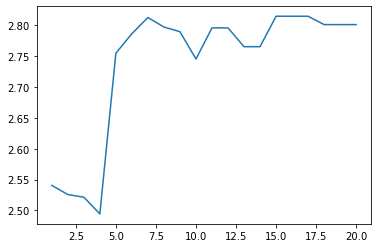

In [9]:
effect_by_k_groups("smokeintensity")

The conclusionare are:
- The effect strongly depends on the distribution of the samples in the averaged groups - different grouping leads to different effect value.
- There is a general upward trend
- However, we do see a convergence of the effect value along with the K values.